Experiments to run:

Note: Fix random seed numpy, pytorch (data splitting), log data to csv files, run each 5 times

1. Dataset:
  1.   Increase training size
  2.   Decrease unlabeled data size

2. Methods:
  1.   Distillation with lambdas: 0., 0.3, 0.5, 0.7, 0.9
  2.   Distillation with unlabeled with soft labels from teacher ../../
  3.   Anchor method with similar lambdas
  4.   Anchor method with unlabeled ../../

3. Metrics:
  1.   Good churn
  2.   Bad churn
  3.   Churn ratio
  4.   Accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import os
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from sklearn.mixture import GaussianMixture
from typing import Union

N_EPOCHS = 50

In [ ]:
# Set the seed for PyTorch
torch.manual_seed(46)

# Set the seed for NumPy
np.random.seed(46)

class ChurnMetric:
    """
    Super class for metrics.
    """

    def __init__(self, tensor_type="numpy") -> None:
        tensor_types = {"numpy": np.ndarray, "torch": torch.Tensor}
        if tensor_type not in tensor_types:
            raise NotImplementedError("Unknown object type")
        self.tensor_type = tensor_types[tensor_type]

    def call_sanitize_inputs(self, **preds):
        """
        preds can be true labels as well
        Shape of tensors need to be the same.
        Tensor dim len must not be >2
        """
        for p in preds:
            if not isinstance(preds[p], self.tensor_type):
                raise TypeError(f"{p} is not an instance of {str(self.tensor_type)}")
            if len(preds[p].shape) > 2:
                raise ValueError(f"Too many dims in {p}")
        shapes = set([preds[p].shape for p in preds])
        if len(shapes) > 1:  # TODO extend to force only first dim to be the same
            raise ValueError(f"shape mismatch. shapes of preds must be same")

    def reshape_argmax(self, **preds):
        for p in preds:
            if len(preds[p].shape) == 2 and preds[p].shape[1] > 1:
                preds[p] = preds[p].argmax(1)
        return (preds[p] for p in preds)


class Churn(ChurnMetric):
    """
    Simple Churn. Calculates number of classification disagreements, along axis:0.
    Will take argmax if multiple columns.
    """

    def __init__(self, tensor_type="numpy", output_mode="proportion") -> None:
        super(Churn, self).__init__(tensor_type=tensor_type)
        if output_mode not in {"proportion", "count"}:
            raise ValueError("Unknown output_mode")
        self.output_mode = output_mode

    def __call__(
        self,
        predA: Union[np.ndarray, torch.Tensor],
        predB: Union[np.ndarray, torch.Tensor],
    ) -> None:
        self.call_sanitize_inputs(predA=predA, predB=predB)
        predA, predB = self.reshape_argmax(predA=predA, predB=predB)

        churn = sum(predA != predB)

        if self.output_mode == "proportion":
            return churn / predA.shape[0]
        if self.output_mode == "count":
            return churn


class WinLossRatio(ChurnMetric):
    """
    Lateral Churns are not loss
    """

    def __init__(self, tensor_type="numpy") -> None:
        super().__init__(tensor_type)

    def __call__(self, true_labels, pred_teacher, pred_student):
        self.call_sanitize_inputs(
            true_labels=true_labels,
            pred_teacher=pred_teacher,
            pred_student=pred_student,
        )
        true_labels, pred_teacher, pred_student = self.reshape_argmax(
            true_labels, pred_teacher, pred_student
        )

        pred_teacher = pred_teacher == true_labels
        pred_student = pred_student == true_labels
        wins = sum(pred_student > pred_teacher)
        losses = sum(pred_student < pred_teacher)

        return wins / (losses + 1e-7)


class ChurnRatio(ChurnMetric):
    def __init__(self, tensor_type="numpy") -> None:
        super().__init__(tensor_type)

    def __call__(self, pred_teacher, pred_student, pred_control):
        self.call_sanitize_inputs(
            pred_teacher=pred_teacher,
            pred_student=pred_student,
            pred_control=pred_control,
        )
        pred_teacher, pred_student, pred_control = self.reshape_argmax(
            pred_teacher, pred_student, pred_control
        )

        churnratio = sum(pred_student != pred_teacher) / sum(
            pred_control != pred_teacher
        )
        return churnratio


class GoodBadChurn(ChurnMetric):
    """
    lateral churn is bad
    """

    def __init__(
        self, tensor_type="numpy", mode=None, output_mode="proportion"
    ) -> None:
        super().__init__(tensor_type)
        if mode is None or mode not in {"good", "bad"}:
            raise ValueError("Please specify mode as good or bad")
        self.mode = mode
        if output_mode not in {"proportion", "count"}:
            raise ValueError("Unknown output_mode")
        self.output_mode = output_mode

    def __call__(self, true_labels, pred_teacher, pred_student):
        self.call_sanitize_inputs(
            true_labels=true_labels,
            pred_teacher=pred_teacher,
            pred_student=pred_student,
        )
        true_labels, pred_teacher, pred_student = self.reshape_argmax(
            true_labels=true_labels, pred_teacher=pred_teacher, pred_student=pred_student,
        )

        if self.mode == "good":
            churn = sum((pred_student == true_labels) > (pred_teacher == true_labels))
            if self.output_mode == "proportion":
                denominator = sum((pred_student == true_labels))
                return churn / denominator
            elif self.output_mode == "count":
                return churn

        elif self.mode == "bad":
            churn = sum(
                (pred_student == true_labels) < (pred_teacher == true_labels)
            ) + sum(
                (pred_student != true_labels)
                & (pred_teacher != true_labels)
                & (pred_teacher != pred_student)
            )
            if self.output_mode == "proportion":
                raise NotImplementedError("IDK")
            elif self.output_mode == "count":
                return churn


Init datasets

In [ ]:
# Set the seed for PyTorch
torch.manual_seed(46)

# Set the seed for NumPy
np.random.seed(46)

#torch transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

new_classes = [3,5,7]
regular_classes = [0,1,2,4,6,8,9]

#Create Train Sets
total_datasets = [
    torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform),
    torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform),
]

total_dict = {
    "x": torch.concat([d.data for d in total_datasets]),
    "y": torch.concat([d.targets for d in total_datasets]),
}
total_dict["id"] = np.array(range(total_dict["y"].shape[0]))
total_dict["field"] = np.array(['NoneNoneNone']*total_dict['y'].shape[0])

for c in regular_classes:
    c_ids = total_dict["id"][np.where(total_dict["y"]==c)[0]]
    field = np.array(["oldtrain"]*4400 + ["test"]*800 + ["val"]*800 + ["unlab"]*1000 + ["new"]*0)
    np.random.shuffle(field)    
    total_dict['field'][c_ids] = field
for c in new_classes:
    c_ids = total_dict["id"][np.where(total_dict["y"]==c)[0]]
    field = np.array(["oldtrain"]*3900 + ["test"]*800 + ["val"]*800 + ["unlab"]*500 + ["new"]*1000)
    np.random.shuffle(field)
    total_dict['field'][c_ids] = field

sets = {
    ss: torch.utils.data.TensorDataset(
        total_dict['x'][total_dict['field']==ss],
        total_dict['y'][total_dict['field']==ss],
    ) for ss in ["oldtrain", "test", "val", "new"]
}
sets["unlab"] = torch.utils.data.TensorDataset(
    total_dict['x'][total_dict['field']=="unlab"],
    total_dict['y'][total_dict['field']=="unlab"],
)
sets['mixed'] = torch.utils.data.TensorDataset(
    torch.concat([
    total_dict['x'][total_dict['field']=="oldtrain"],
    total_dict['x'][total_dict['field']=="new"],
]),
torch.concat([
    total_dict['y'][total_dict['field']=="oldtrain"],
    total_dict['y'][total_dict['field']=="new"],
])
)

Model architecture

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential( #28*28
#             nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(6),
#             nn.MaxPool2d(2),
#             nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.MaxPool2d(2),
#         )
#         self.fully_connected = nn.Sequential(
#             nn.Linear(in_features=16*5*5, out_features=120),
#             nn.ReLU(),
#             nn.Dropout(0.25),
#             nn.BatchNorm1d(120),
#             nn.Linear(in_features=120, out_features=84),
#             nn.ReLU(),
#             nn.Dropout(0.25),
#             nn.BatchNorm1d(84),
#             nn.Linear(in_features=84, out_features=10),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.fully_connected(x)
#         return x

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


### Simple CNN

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(32 * 7 * 7, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = x.view(-1, 32 * 7 * 7)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

Init models

In [ ]:
batch_size = 256
loaders = {
    ss: torch.utils.data.DataLoader(sets[ss], batch_size=batch_size, shuffle=False)
    for ss in ["oldtrain", "mixed", "test", "unlab", "val", "new"]
}

Train Teacher

In [ ]:
from copy import deepcopy

def train(name, loader, init_val_loss=1e7, n_epochs=N_EPOCHS):
    # Set the seed for PyTorch
    torch.manual_seed(46)

    # Set the seed for NumPy
    np.random.seed(46)
    model = CNN()
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    n_epochs = n_epochs
    best_val_loss = init_val_loss
    best_state_dict = deepcopy(model.state_dict())
    loss_fn = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        # running_loss = 0.0
        for i, (x,y) in tqdm(enumerate(loader), disable=True,):
            x = x.unsqueeze(1).float()
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step() 
        print('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, n_epochs, loss.item()))

            
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i,data in enumerate(loader):
                x, y = data
                x = x.to(device)
                y = y.to(device)
                x = x.unsqueeze(1).float()
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                val_loss += loss_fn(outputs, y).item()
            if val_loss < best_val_loss:
                model.to('cpu')
                model.eval()
                torch.save(model.state_dict(), name+".pth")
                model.train()
                model.to(device)
                best_val_loss = val_loss
                # print(f"best at epoch {epoch}")
        # print('[%d] validation loss: %.5f' % (epoch+1, val_loss))
                print('Accuracy of the model on the test images: {:.2f} %'.format(100 * correct / total))
                print('Validation error of the model on the test images: {:.4f}'.format(val_loss / len(loader)))
    return model


In [ ]:
def train_dist(name, loader, init_val_loss=1e7, n_epochs=N_EPOCHS):
    # Set the seed for PyTorch
    torch.manual_seed(46)

    # Set the seed for NumPy
    np.random.seed(46)
    model = CNN()
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    n_epochs = n_epochs
    best_val_loss = init_val_loss
    loss_fn = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        # running_loss = 0.0
        for i, (x,y) in tqdm(enumerate(loader), disable=True,):
            x = x.unsqueeze(1).float()
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step() 
        print('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, n_epochs, loss.item()))

            
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i,data in enumerate(loader):
                x, y = data
                x = x.to(device)
                y = y.to(device)
                x = x.unsqueeze(1).float()
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                _, dist_y = torch.max(y.data, 1)
                total += y.size(0)
                correct += (predicted == dist_y).sum().item()
                val_loss += loss_fn(outputs, y).item()
            if val_loss < best_val_loss:
                model.to('cpu')
                model.eval()
                torch.save(model.state_dict(), name+".pth")
                model.train()
                model.to(device)
                best_val_loss = val_loss
                # print(f"best at epoch {epoch}")
        # print('[%d] validation loss: %.5f' % (epoch+1, val_loss))
                print('Accuracy of the model on the test images: {:.2f} %'.format(100 * correct / total))
                print('Validation error of the model on the test images: {:.4f}'.format(val_loss / len(loader)))
    return model

Generate Teacher Predicted Labels

In [ ]:
train(
    name="teacher_model", 
    loader=loaders["oldtrain"],
)
teacher_model = CNN()
teacher_model.load_state_dict(torch.load("teacher_model.pth"))
teacher_model.eval()
None

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/50], Loss: 0.1692
Accuracy of the model on the test images: 81.05 %
Validation error of the model on the test images: 0.5255
Epoch [2/50], Loss: 0.3007
Accuracy of the model on the test images: 83.75 %
Validation error of the model on the test images: 0.4465
Epoch [3/50], Loss: 0.1597
Accuracy of the model on the test images: 85.65 %
Validation error of the model on the test images: 0.3929
Epoch [4/50], Loss: 0.0016
Accuracy of the model on the test images: 86.65 %
Validation error of the model on the test images: 0.3683
Epoch [5/50], Loss: 0.0156
Accuracy of the model on the test images: 87.00 %
Validation error of the model on the test images: 0.3560
Epoch [6/50], Loss: 0.0319
Accuracy of the model on the test images: 87.29 %
Validation error of the model on the test images: 0.3421
Epoch [7/50], Loss: 0.0006
Accuracy of the model on the test images: 88.41 %
Validation error of the model on the test images: 0.3136
Epoch [8/50], Loss: 0.0979
Accuracy of the model on the test i

In [ ]:
#Get train labels on train mixed data
with torch.no_grad():
    teacher_labels_mixed = []
    for (x,y) in tqdm(loaders['mixed']):
        x = x.unsqueeze(1).float()
        pred = teacher_model(x)
        teacher_labels_mixed.append(pred)
    teacher_labels_mixed = torch.concatenate(teacher_labels_mixed).argmax(dim=1)
sets['teacher_mixed'] = torch.utils.data.TensorDataset(
    torch.concat([
    total_dict['x'][total_dict['field']=="oldtrain"],
    total_dict['x'][total_dict['field']=="new"],
]),
    teacher_labels_mixed,
)

100%|██████████| 178/178 [00:24<00:00,  7.12it/s]


In [ ]:
import torch.nn.functional as F

# Get train labels on unlabelled data
with torch.no_grad():
    unlab_teacherpred = []
    for (x,i) in tqdm(loaders['unlab']):
        x = x.unsqueeze(1).float()
        pred = teacher_model(x)
        probs = F.softmax(pred, dim=1)
        unlab_teacherpred.append(probs)
    unlab_teacherpred = torch.cat(unlab_teacherpred, dim=0)  # Concatenate the list of tensors


  # 0.1, 0.8, 0.1 : conf=0.8, pred=1
  # 0.1, 0.3, 0.6 : conf=0.6, pred=2

100%|██████████| 34/34 [00:06<00:00,  5.23it/s]


In [ ]:
# unlab_teacherpred_conf, unlab_teacherpred = torch.concatenate(unlab_teacherpred).max(dim=1)

### Misclassifications

In [ ]:
true_mix = torch.concat([
    total_dict['y'][total_dict['field']=="oldtrain"],
    total_dict['y'][total_dict['field']=="new"],
])

teacher_labels_mixed

# Compare the tensors element-wise
mask = true_mix != teacher_labels_mixed

# Get the indices of the non-matching elements
indices = torch.where(mask)


In [ ]:
# get the unique elements and their counts
unique, counts = torch.unique(true_mix[indices[0]], return_counts=True)

# print the results
for u, c in zip(unique, np.round(100*counts/len(true_mix),2)):
    print('Element {}: {:.2f}%'.format(u, c))

Element 0: 0.51%
Element 1: 0.01%
Element 2: 0.41%
Element 3: 0.27%
Element 4: 0.18%
Element 5: 0.04%
Element 6: 0.44%
Element 7: 0.07%
Element 8: 0.01%
Element 9: 0.06%


## Adding Unlabeled Data

In [ ]:
X_new = total_dict['x'][total_dict['field']=="new"].flatten(start_dim=1).numpy()
X_mixed = torch.concat([
    total_dict['x'][total_dict['field']=="oldtrain"],
    total_dict['x'][total_dict['field']=="new"],
]).flatten(start_dim=1).numpy()
X_unlab = total_dict['x'][total_dict['field']=="unlab"].flatten(start_dim=1).numpy()
y_mixed = torch.concat([
    total_dict['y'][total_dict['field']=="oldtrain"],
    total_dict['y'][total_dict['field']=="new"],
])


In [ ]:
#relabel based on threshold
confidence_threshold = 1.0

# gmm_labels = teacher_labels_mixed
lamda = 0.0
gmm_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * (lamda) + F.one_hot(sets['mixed'].tensors[1], num_classes=10) * (1-lamda)
#gmm_labels[loglik_mixed > threshold] = y_mixed[loglik_mixed > threshold]
#unlabeled data
# unlab_condition = torch.isin(unlab_teacherpred, torch.tensor(regular_classes))
sets["teacher_unlab"] = torch.utils.data.TensorDataset(
    total_dict['x'][np.isin(total_dict['field'], ["unlab"])],
    unlab_teacherpred
)

sets["gmm"] = torch.utils.data.TensorDataset(
    torch.concat([
        sets['mixed'].tensors[0],
        sets['unlab'].tensors[0],
    ]),
    torch.concat([
        gmm_labels,
       unlab_teacherpred
    ]),
)
loaders['gmm'] = torch.utils.data.DataLoader(sets["gmm"], batch_size=batch_size, shuffle=False)

In [ ]:
#y_new = total_dict['y'][total_dict['field']=="new"]

In [ ]:
#y_unlab = total_dict['y'][total_dict['field']=="unlab"].flatten(start_dim=0).numpy()

Train unlabel based CNN model

In [ ]:
train_dist(
    name="student_unlab_model", 
    loader=loaders['gmm'],
)
student_gmm_model = CNN()
student_gmm_model.load_state_dict(torch.load("student_unlab_model.pth"))
student_gmm_model.eval()
None

Epoch [1/50], Loss: 0.5633
Accuracy of the model on the test images: 81.47 %
Validation error of the model on the test images: 0.5273
Epoch [2/50], Loss: 0.5299
Accuracy of the model on the test images: 83.54 %
Validation error of the model on the test images: 0.4609
Epoch [3/50], Loss: 0.4500
Accuracy of the model on the test images: 84.71 %
Validation error of the model on the test images: 0.4298
Epoch [4/50], Loss: 0.4225
Accuracy of the model on the test images: 86.07 %
Validation error of the model on the test images: 0.3960
Epoch [5/50], Loss: 0.3966
Accuracy of the model on the test images: 86.82 %
Validation error of the model on the test images: 0.3720
Epoch [6/50], Loss: 0.3849
Accuracy of the model on the test images: 87.21 %
Validation error of the model on the test images: 0.3543
Epoch [7/50], Loss: 0.3550
Accuracy of the model on the test images: 87.69 %
Validation error of the model on the test images: 0.3450
Epoch [8/50], Loss: 0.3332
Accuracy of the model on the test i

## Anchor Method

In [ ]:
lamda = 0.0
distill_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * (lamda) + F.one_hot(sets['mixed'].tensors[1], num_classes=10) * (1-lamda)

sets["distill"] = torch.utils.data.TensorDataset(
    sets['mixed'].tensors[0],
    distill_labels,
)

loaders['distill'] = torch.utils.data.DataLoader(sets['distill'], batch_size=batch_size, shuffle=False)

In [ ]:
loader=loaders['distill']

In [ ]:
train_dist(
    name="student_anchor_model", 
    loader=loaders['distill'],
)
student_anchor_model = CNN()
student_anchor_model.load_state_dict(torch.load("student_anchor_model.pth"))
student_anchor_model.eval()
None

Epoch [1/50], Loss: 0.0883
Accuracy of the model on the test images: 48.77 %
Validation error of the model on the test images: 3.2416
Epoch [2/50], Loss: 0.1086
Accuracy of the model on the test images: 66.27 %
Validation error of the model on the test images: 1.4393
Epoch [3/50], Loss: 0.1296
Accuracy of the model on the test images: 71.32 %
Validation error of the model on the test images: 1.0030
Epoch [4/50], Loss: 0.0601
Accuracy of the model on the test images: 74.85 %
Validation error of the model on the test images: 0.8972
Epoch [5/50], Loss: 0.0711
Accuracy of the model on the test images: 76.16 %
Validation error of the model on the test images: 0.8404
Epoch [6/50], Loss: 0.0757
Accuracy of the model on the test images: 78.10 %
Validation error of the model on the test images: 0.7385
Epoch [7/50], Loss: 0.0910
Accuracy of the model on the test images: 82.91 %
Validation error of the model on the test images: 0.5283
Epoch [8/50], Loss: 0.0604
Accuracy of the model on the test i

## Baseline Method

In [ ]:
train(
    name="baseline_model", 
    loader=loaders['mixed'],
)
baseline_model = CNN()
baseline_model.load_state_dict(torch.load("baseline_model.pth"))
baseline_model.eval()
None

Epoch [1/50], Loss: 0.0941
Accuracy of the model on the test images: 50.11 %
Validation error of the model on the test images: 3.2108
Epoch [2/50], Loss: 0.1612
Accuracy of the model on the test images: 52.31 %
Validation error of the model on the test images: 3.0461
Epoch [3/50], Loss: 0.1084
Accuracy of the model on the test images: 73.00 %
Validation error of the model on the test images: 1.0254
Epoch [4/50], Loss: 0.0623
Accuracy of the model on the test images: 73.57 %
Validation error of the model on the test images: 0.9694
Epoch [5/50], Loss: 0.0696
Accuracy of the model on the test images: 75.88 %
Validation error of the model on the test images: 0.8134
Epoch [6/50], Loss: 0.0816
Accuracy of the model on the test images: 81.35 %
Validation error of the model on the test images: 0.5901
Epoch [7/50], Loss: 0.0941
Epoch [8/50], Loss: 0.0600
Accuracy of the model on the test images: 82.92 %
Validation error of the model on the test images: 0.5148
Epoch [9/50], Loss: 0.0592
Epoch [1

In [ ]:
def accuracy(pred, true):
    return 100 * (pred==true).sum() / pred.shape[0]

def get_metrics(targets, loader):
    with torch.no_grad():
        good_churn = GoodBadChurn(mode="good", tensor_type="torch", output_mode = "count")
        bad_churn = GoodBadChurn(mode="bad", tensor_type="torch", output_mode = "count")
        pred_teacher = []
        pred_baseline = []
        pred_distill = []
        pred_gmm = []
        for (x,y) in tqdm(loader):
            x = x.unsqueeze(1).float()
            pred = teacher_model(x)
            pred_teacher.append(pred)
            pred = baseline_model(x)
            pred_baseline.append(pred)
            pred = student_anchor_model(x)
            pred_distill.append(pred)
            pred = student_gmm_model(x)
            pred_gmm.append(pred)
        pred_teacher = torch.concatenate(pred_teacher).argmax(dim=1)
        pred_baseline = torch.concatenate(pred_baseline).argmax(dim=1)
        pred_distill = torch.concatenate(pred_distill).argmax(dim=1)
        pred_gmm = torch.concatenate(pred_gmm).argmax(dim=1)
        
        gchurns = {
            "baseline": good_churn(targets, pred_teacher, pred_baseline).item(),
            "add_unlab": good_churn(targets, pred_teacher, pred_gmm).item(),
            "anchor": good_churn(targets, pred_teacher, pred_distill).item(),
        }
        bchurns = {
            "baseline": bad_churn(targets, pred_teacher, pred_baseline).item(),
            "add_unlab": bad_churn(targets, pred_teacher, pred_gmm).item(),
            "anchor": bad_churn(targets, pred_teacher, pred_distill).item(),
        }
        accuracies = {
            "baseline": accuracy(pred_baseline, targets).item(),
            "add_unlab": accuracy(pred_gmm, targets).item(),
            "anchor": accuracy(pred_distill, targets).item(),
            "teacher": accuracy(pred_teacher, targets).item(),
        }
        return gchurns, bchurns, accuracies
        

In [ ]:
metrics_dict = {   "gchurns_val":  {'baseline': 0, 'add_unlab': 0, 'anchor': 0},
                  "bchurns_val":  {'baseline': 0, 'add_unlab': 0, 'anchor': 0}, 
                  "accuracies_val": {'baseline': 0, 'add_unlab': 0, 'anchor': 0}}

metrics_dict_multiple = {
    x: metrics_dict.copy()
    for x in [0.0, 0.3, 0.5, 0.7, 0.9]
}

In [ ]:
# gchurns_mixed, bchurns_mixed, accuracies_mixed = get_metrics(sets['mixed'].tensors[1], loaders['mixed'])
# metrics_dict_multiple[0.0]["gchurns_mixed"] = gchurns_mixed
# metrics_dict_multiple[0.0]["bchurns_mixed"] = bchurns_mixed
# metrics_dict_multiple[0.0]["accuracies_mixed"] = accuracies_mixed

In [ ]:
gchurns_val, bchurns_val, accuracies_val = get_metrics(sets['val'].tensors[1], loaders['val'])
metrics_dict_multiple[0.0]["gchurns_val"] = gchurns_val
metrics_dict_multiple[0.0]["bchurns_val"] = bchurns_val
metrics_dict_multiple[0.0]["accuracies_val"] = accuracies_val

100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Lambda = 0.3

In [ ]:
#relabel based on threshold
confidence_threshold = 1.0

# gmm_labels = teacher_labels_mixed
lamda = 0.3

mixed_label = F.one_hot(sets['mixed'].tensors[1], num_classes=10)
gmm_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * lamda + mixed_label * (1 - lamda)
gmm_labels = torch.where(mixed_label != F.one_hot(y_mixed, num_classes=10), mixed_label, gmm_labels)


sets["teacher_unlab"] = torch.utils.data.TensorDataset(
    total_dict['x'][np.isin(total_dict['field'], ["unlab"])],
    unlab_teacherpred
)

sets["gmm"] = torch.utils.data.TensorDataset(
    torch.concat([
        sets['mixed'].tensors[0],
        sets['unlab'].tensors[0],
    ]),
    torch.concat([
        gmm_labels,
       unlab_teacherpred
    ]),
)
loaders['gmm'] = torch.utils.data.DataLoader(sets["gmm"], batch_size=batch_size, shuffle=False)

train_dist(
    name="student_unlab_model", 
    loader=loaders['gmm'],
)
student_gmm_model = CNN()
student_gmm_model.load_state_dict(torch.load("student_unlab_model.pth"))
student_gmm_model.eval()
None

Epoch [1/50], Loss: 0.5497
Accuracy of the model on the test images: 82.22 %
Validation error of the model on the test images: 0.5053
Epoch [2/50], Loss: 0.4863
Accuracy of the model on the test images: 84.52 %
Validation error of the model on the test images: 0.4288
Epoch [3/50], Loss: 0.4366
Accuracy of the model on the test images: 86.25 %
Validation error of the model on the test images: 0.3903
Epoch [4/50], Loss: 0.4056
Accuracy of the model on the test images: 86.45 %
Validation error of the model on the test images: 0.3766
Epoch [5/50], Loss: 0.3507
Accuracy of the model on the test images: 87.54 %
Validation error of the model on the test images: 0.3415
Epoch [6/50], Loss: 0.3635
Accuracy of the model on the test images: 87.87 %
Validation error of the model on the test images: 0.3286
Epoch [7/50], Loss: 0.3474
Accuracy of the model on the test images: 88.62 %
Validation error of the model on the test images: 0.3096
Epoch [8/50], Loss: 0.3261
Accuracy of the model on the test i

In [ ]:
lamda = 0.3
distill_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * (lamda) + F.one_hot(sets['mixed'].tensors[1], num_classes=10) * (1-lamda)

sets["distill"] = torch.utils.data.TensorDataset(
    sets['mixed'].tensors[0],
    distill_labels,
)

loaders['distill'] = torch.utils.data.DataLoader(sets['distill'], batch_size=batch_size, shuffle=False)

loader=loaders['distill']

train_dist(
    name="student_anchor_model", 
    loader=loaders['distill'],
)
student_anchor_model = CNN()
student_anchor_model.load_state_dict(torch.load("student_anchor_model.pth"))
student_anchor_model.eval()
None

Epoch [1/50], Loss: 0.1264
Accuracy of the model on the test images: 61.25 %
Validation error of the model on the test images: 1.6948
Epoch [2/50], Loss: 0.1482
Accuracy of the model on the test images: 64.87 %
Validation error of the model on the test images: 1.4355
Epoch [3/50], Loss: 0.1389
Accuracy of the model on the test images: 76.58 %
Validation error of the model on the test images: 0.7517
Epoch [4/50], Loss: 0.0900
Epoch [5/50], Loss: 0.0975
Accuracy of the model on the test images: 80.54 %
Validation error of the model on the test images: 0.6082
Epoch [6/50], Loss: 0.0933
Accuracy of the model on the test images: 81.91 %
Validation error of the model on the test images: 0.5737
Epoch [7/50], Loss: 0.1394
Epoch [8/50], Loss: 0.0777
Accuracy of the model on the test images: 84.28 %
Validation error of the model on the test images: 0.4541
Epoch [9/50], Loss: 0.0966
Epoch [10/50], Loss: 0.0958
Accuracy of the model on the test images: 85.38 %
Validation error of the model on the 

In [ ]:
# gchurns_mixed, bchurns_mixed, accuracies_mixed = get_metrics(sets['mixed'].tensors[1], loaders['mixed'])
# metrics_dict_multiple[0.3]["gchurns_mixed"] = gchurns_mixed
# metrics_dict_multiple[0.3]["bchurns_mixed"] = bchurns_mixed
# metrics_dict_multiple[0.3]["accuracies_mixed"] = accuracies_mixed

gchurns_val, bchurns_val, accuracies_val = get_metrics(sets['val'].tensors[1], loaders['val'])
metrics_dict_multiple[0.3]["gchurns_val"] = gchurns_val
metrics_dict_multiple[0.3]["bchurns_val"] = bchurns_val
metrics_dict_multiple[0.3]["accuracies_val"] = accuracies_val


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


### Lambda = 0.5

In [ ]:
#relabel based on threshold
confidence_threshold = 1.0

# gmm_labels = teacher_labels_mixed
lamda = 0.5

mixed_label = F.one_hot(sets['mixed'].tensors[1], num_classes=10)
gmm_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * lamda + mixed_label * (1 - lamda)
gmm_labels = torch.where(mixed_label != F.one_hot(y_mixed, num_classes=10), mixed_label, gmm_labels)


sets["teacher_unlab"] = torch.utils.data.TensorDataset(
    total_dict['x'][np.isin(total_dict['field'], ["unlab"])],
    unlab_teacherpred
)

sets["gmm"] = torch.utils.data.TensorDataset(
    torch.concat([
        sets['mixed'].tensors[0],
        sets['unlab'].tensors[0],
    ]),
    torch.concat([
        gmm_labels,
       unlab_teacherpred
    ]),
)
loaders['gmm'] = torch.utils.data.DataLoader(sets["gmm"], batch_size=batch_size, shuffle=False)


train_dist(
    name="student_unlab_model", 
    loader=loaders['gmm'],
)
student_gmm_model = CNN()
student_gmm_model.load_state_dict(torch.load("student_unlab_model.pth"))
student_gmm_model.eval()
None

Epoch [1/50], Loss: 0.5675
Accuracy of the model on the test images: 82.57 %
Validation error of the model on the test images: 0.4909
Epoch [2/50], Loss: 0.4880
Accuracy of the model on the test images: 85.39 %
Validation error of the model on the test images: 0.4120
Epoch [3/50], Loss: 0.4470
Accuracy of the model on the test images: 86.58 %
Validation error of the model on the test images: 0.3800
Epoch [4/50], Loss: 0.3906
Accuracy of the model on the test images: 87.72 %
Validation error of the model on the test images: 0.3460
Epoch [5/50], Loss: 0.3348
Accuracy of the model on the test images: 88.42 %
Validation error of the model on the test images: 0.3287
Epoch [6/50], Loss: 0.3459
Accuracy of the model on the test images: 88.14 %
Validation error of the model on the test images: 0.3258
Epoch [7/50], Loss: 0.3240
Accuracy of the model on the test images: 89.40 %
Validation error of the model on the test images: 0.2965
Epoch [8/50], Loss: 0.3303
Accuracy of the model on the test i

In [ ]:
lamda = 0.5
distill_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * (lamda) + F.one_hot(sets['mixed'].tensors[1], num_classes=10) * (1-lamda)

sets["distill"] = torch.utils.data.TensorDataset(
    sets['mixed'].tensors[0],
    distill_labels,
)

loaders['distill'] = torch.utils.data.DataLoader(sets['distill'], batch_size=batch_size, shuffle=False)

loader=loaders['distill']

train_dist(
    name="student_anchor_model", 
    loader=loaders['distill'],
)
student_anchor_model = CNN()
student_anchor_model.load_state_dict(torch.load("student_anchor_model.pth"))
student_anchor_model.eval()
None

Epoch [1/50], Loss: 0.1431
Accuracy of the model on the test images: 63.44 %
Validation error of the model on the test images: 1.4643
Epoch [2/50], Loss: 0.1623
Accuracy of the model on the test images: 74.72 %
Validation error of the model on the test images: 0.8787
Epoch [3/50], Loss: 0.1342
Accuracy of the model on the test images: 77.62 %
Validation error of the model on the test images: 0.6833
Epoch [4/50], Loss: 0.0885
Accuracy of the model on the test images: 81.47 %
Validation error of the model on the test images: 0.5857
Epoch [5/50], Loss: 0.1006
Accuracy of the model on the test images: 82.76 %
Validation error of the model on the test images: 0.5438
Epoch [6/50], Loss: 0.0955
Accuracy of the model on the test images: 84.91 %
Validation error of the model on the test images: 0.4407
Epoch [7/50], Loss: 0.1084
Epoch [8/50], Loss: 0.0775
Accuracy of the model on the test images: 86.00 %
Validation error of the model on the test images: 0.4160
Epoch [9/50], Loss: 0.0892
Accuracy

In [ ]:
# gchurns_mixed, bchurns_mixed, accuracies_mixed = get_metrics(sets['mixed'].tensors[1], loaders['mixed'])
# metrics_dict_multiple[0.5]["gchurns_mixed"] = gchurns_mixed
# metrics_dict_multiple[0.5]["bchurns_mixed"] = bchurns_mixed
# metrics_dict_multiple[0.5]["accuracies_mixed"] = accuracies_mixed

gchurns_val, bchurns_val, accuracies_val = get_metrics(sets['val'].tensors[1], loaders['val'])
metrics_dict_multiple[0.5]["gchurns_val"] = gchurns_val
metrics_dict_multiple[0.5]["bchurns_val"] = bchurns_val
metrics_dict_multiple[0.5]["accuracies_val"] = accuracies_val

100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


### Lambda = 0.7

In [ ]:
#relabel based on threshold
confidence_threshold = 1.0

# gmm_labels = teacher_labels_mixed
lamda = 0.7

mixed_label = F.one_hot(sets['mixed'].tensors[1], num_classes=10)
gmm_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * lamda + mixed_label * (1 - lamda)
gmm_labels = torch.where(mixed_label != F.one_hot(y_mixed, num_classes=10), mixed_label, gmm_labels)

sets["teacher_unlab"] = torch.utils.data.TensorDataset(
    total_dict['x'][np.isin(total_dict['field'], ["unlab"])],
    unlab_teacherpred
)

sets["gmm"] = torch.utils.data.TensorDataset(
    torch.concat([
        sets['mixed'].tensors[0],
        sets['unlab'].tensors[0],
    ]),
    torch.concat([
        gmm_labels,
       unlab_teacherpred
    ]),
)
loaders['gmm'] = torch.utils.data.DataLoader(sets["gmm"], batch_size=batch_size, shuffle=False)

train_dist(
    name="student_unlab_model", 
    loader=loaders['gmm'],
)
student_gmm_model = CNN()
student_gmm_model.load_state_dict(torch.load("student_unlab_model.pth"))
student_gmm_model.eval()
None

Epoch [1/50], Loss: 0.5537
Accuracy of the model on the test images: 83.26 %
Validation error of the model on the test images: 0.4799
Epoch [2/50], Loss: 0.4857
Accuracy of the model on the test images: 85.80 %
Validation error of the model on the test images: 0.4076
Epoch [3/50], Loss: 0.4078
Accuracy of the model on the test images: 87.64 %
Validation error of the model on the test images: 0.3587
Epoch [4/50], Loss: 0.3881
Accuracy of the model on the test images: 88.56 %
Validation error of the model on the test images: 0.3350
Epoch [5/50], Loss: 0.3491
Accuracy of the model on the test images: 89.06 %
Validation error of the model on the test images: 0.3212
Epoch [6/50], Loss: 0.3437
Accuracy of the model on the test images: 89.65 %
Validation error of the model on the test images: 0.2980
Epoch [7/50], Loss: 0.3105
Accuracy of the model on the test images: 90.36 %
Validation error of the model on the test images: 0.2822
Epoch [8/50], Loss: 0.3151
Accuracy of the model on the test i

In [ ]:
lamda = 0.7
distill_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * (lamda) + F.one_hot(sets['mixed'].tensors[1], num_classes=10) * (1-lamda)

sets["distill"] = torch.utils.data.TensorDataset(
    sets['mixed'].tensors[0],
    distill_labels,
)

loaders['distill'] = torch.utils.data.DataLoader(sets['distill'], batch_size=batch_size, shuffle=False)

loader=loaders['distill']

train_dist(
    name="student_anchor_model", 
    loader=loaders['distill'],
)
student_anchor_model = CNN()
student_anchor_model.load_state_dict(torch.load("student_anchor_model.pth"))
student_anchor_model.eval()
None

Epoch [1/50], Loss: 0.1357
Accuracy of the model on the test images: 70.05 %
Validation error of the model on the test images: 1.0321
Epoch [2/50], Loss: 0.1412
Accuracy of the model on the test images: 75.95 %
Validation error of the model on the test images: 0.7811
Epoch [3/50], Loss: 0.1407
Accuracy of the model on the test images: 81.45 %
Validation error of the model on the test images: 0.5562
Epoch [4/50], Loss: 0.0880
Accuracy of the model on the test images: 82.50 %
Validation error of the model on the test images: 0.5467
Epoch [5/50], Loss: 0.1100
Accuracy of the model on the test images: 84.35 %
Validation error of the model on the test images: 0.4826
Epoch [6/50], Loss: 0.0968
Accuracy of the model on the test images: 85.29 %
Validation error of the model on the test images: 0.4344
Epoch [7/50], Loss: 0.1001
Epoch [8/50], Loss: 0.0720
Accuracy of the model on the test images: 86.73 %
Validation error of the model on the test images: 0.3932
Epoch [9/50], Loss: 0.1096
Accuracy

In [ ]:
# gchurns_mixed, bchurns_mixed, accuracies_mixed = get_metrics(sets['mixed'].tensors[1], loaders['mixed'])
# metrics_dict_multiple[0.7]["gchurns_mixed"] = gchurns_mixed
# metrics_dict_multiple[0.7]["bchurns_mixed"] = bchurns_mixed
# metrics_dict_multiple[0.7]["accuracies_mixed"] = accuracies_mixed

gchurns_val, bchurns_val, accuracies_val = get_metrics(sets['val'].tensors[1], loaders['val'])
metrics_dict_multiple[0.7]["gchurns_val"] = gchurns_val
metrics_dict_multiple[0.7]["bchurns_val"] = bchurns_val
metrics_dict_multiple[0.7]["accuracies_val"] = accuracies_val


100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


### Lambda = 0.9

In [ ]:
#relabel based on threshold
confidence_threshold = 1.0

# gmm_labels = teacher_labels_mixed
lamda = 0.9

mixed_label = F.one_hot(sets['mixed'].tensors[1], num_classes=10)
gmm_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * lamda + mixed_label * (1 - lamda)
gmm_labels = torch.where(mixed_label != F.one_hot(y_mixed, num_classes=10), mixed_label, gmm_labels)

sets["teacher_unlab"] = torch.utils.data.TensorDataset(
    total_dict['x'][np.isin(total_dict['field'], ["unlab"])],
    unlab_teacherpred
)

sets["gmm"] = torch.utils.data.TensorDataset(
    torch.concat([
        sets['mixed'].tensors[0],
        sets['unlab'].tensors[0],
    ]),
    torch.concat([
        gmm_labels,
       unlab_teacherpred
    ]),
)
loaders['gmm'] = torch.utils.data.DataLoader(sets["gmm"], batch_size=batch_size, shuffle=False)
train_dist(
    name="student_unlab_model", 
    loader=loaders['gmm'],
)
student_gmm_model = CNN()
student_gmm_model.load_state_dict(torch.load("student_unlab_model.pth"))
student_gmm_model.eval()
None

Epoch [1/50], Loss: 0.5557
Accuracy of the model on the test images: 83.65 %
Validation error of the model on the test images: 0.4680
Epoch [2/50], Loss: 0.4719
Accuracy of the model on the test images: 86.54 %
Validation error of the model on the test images: 0.3836
Epoch [3/50], Loss: 0.4135
Accuracy of the model on the test images: 87.81 %
Validation error of the model on the test images: 0.3488
Epoch [4/50], Loss: 0.3974
Accuracy of the model on the test images: 88.68 %
Validation error of the model on the test images: 0.3236
Epoch [5/50], Loss: 0.3414
Accuracy of the model on the test images: 89.27 %
Validation error of the model on the test images: 0.3049
Epoch [6/50], Loss: 0.3322
Accuracy of the model on the test images: 89.50 %
Validation error of the model on the test images: 0.2940
Epoch [7/50], Loss: 0.3222
Accuracy of the model on the test images: 90.88 %
Validation error of the model on the test images: 0.2605
Epoch [8/50], Loss: 0.3313
Accuracy of the model on the test i

In [ ]:
lamda = 0.9
distill_labels = F.one_hot(teacher_labels_mixed, num_classes=10) * (lamda) + F.one_hot(sets['mixed'].tensors[1], num_classes=10) * (1-lamda)

sets["distill"] = torch.utils.data.TensorDataset(
    sets['mixed'].tensors[0],
    distill_labels,
)

loaders['distill'] = torch.utils.data.DataLoader(sets['distill'], batch_size=batch_size, shuffle=False)

loader=loaders['distill']

train_dist(
    name="student_anchor_model", 
    loader=loaders['distill'],
)
student_anchor_model = CNN()
student_anchor_model.load_state_dict(torch.load("student_anchor_model.pth"))
student_anchor_model.eval()
None

Epoch [1/50], Loss: 0.1414
Accuracy of the model on the test images: 74.69 %
Validation error of the model on the test images: 0.8081
Epoch [2/50], Loss: 0.1426
Accuracy of the model on the test images: 79.48 %
Validation error of the model on the test images: 0.6259
Epoch [3/50], Loss: 0.1368
Accuracy of the model on the test images: 81.47 %
Validation error of the model on the test images: 0.5295
Epoch [4/50], Loss: 0.1068
Accuracy of the model on the test images: 83.43 %
Validation error of the model on the test images: 0.4934
Epoch [5/50], Loss: 0.0983
Accuracy of the model on the test images: 85.26 %
Validation error of the model on the test images: 0.4410
Epoch [6/50], Loss: 0.0920
Accuracy of the model on the test images: 87.09 %
Validation error of the model on the test images: 0.3688
Epoch [7/50], Loss: 0.1161
Epoch [8/50], Loss: 0.0700
Accuracy of the model on the test images: 88.49 %
Validation error of the model on the test images: 0.3324
Epoch [9/50], Loss: 0.0983
Epoch [1

In [ ]:
# gchurns_mixed, bchurns_mixed, accuracies_mixed = get_metrics(sets['mixed'].tensors[1], loaders['mixed'])
# metrics_dict_multiple[0.9]["gchurns_mixed"] = gchurns_mixed
# metrics_dict_multiple[0.9]["bchurns_mixed"] = bchurns_mixed
# metrics_dict_multiple[0.9]["accuracies_mixed"] = accuracies_mixed

gchurns_val, bchurns_val, accuracies_val = get_metrics(sets['val'].tensors[1], loaders['val'])
metrics_dict_multiple[0.9]["gchurns_val"] = gchurns_val
metrics_dict_multiple[0.9]["bchurns_val"] = bchurns_val
metrics_dict_multiple[0.9]["accuracies_val"] = accuracies_val


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


In [ ]:
metrics_dict_multiple

{0.0: {'gchurns_val': {'baseline': 176, 'add_unlab': 124, 'anchor': 170},
  'bchurns_val': {'baseline': 286, 'add_unlab': 221, 'anchor': 299},
  'accuracies_val': {'baseline': 91.4749984741211,
   'add_unlab': 91.4124984741211,
   'anchor': 91.2125015258789,
   'teacher': 92.0250015258789}},
 0.3: {'gchurns_val': {'baseline': 176, 'add_unlab': 106, 'anchor': 160},
  'bchurns_val': {'baseline': 286, 'add_unlab': 216, 'anchor': 254},
  'accuracies_val': {'baseline': 91.4749984741211,
   'add_unlab': 91.30000305175781,
   'anchor': 91.6500015258789,
   'teacher': 92.0250015258789}},
 0.5: {'gchurns_val': {'baseline': 176, 'add_unlab': 113, 'anchor': 141},
  'bchurns_val': {'baseline': 286, 'add_unlab': 215, 'anchor': 248},
  'accuracies_val': {'baseline': 91.4749984741211,
   'add_unlab': 91.32499694824219,
   'anchor': 91.51249694824219,
   'teacher': 92.0250015258789}},
 0.7: {'gchurns_val': {'baseline': 176, 'add_unlab': 108, 'anchor': 138},
  'bchurns_val': {'baseline': 286, 'add_unla

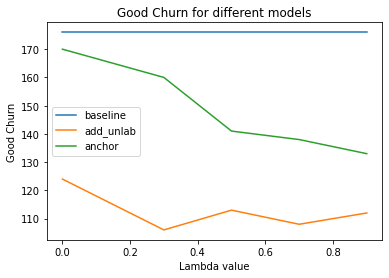

In [ ]:
import matplotlib.pyplot as plt

hyperparams = [0.0, 0.3, 0.5, 0.7, 0.9]

# plot accuracies for each model
for model in ['baseline', 'add_unlab', 'anchor']:
    model_accuracies = []
    for hyperparam in hyperparams:
        model_accuracies.append(metrics_dict_multiple[hyperparam]['gchurns_val'][model])
    plt.plot(hyperparams, model_accuracies, label=model)

plt.title('Good Churn for different models')
plt.xlabel('Lambda value')
plt.ylabel('Good Churn')
plt.legend()
plt.show()


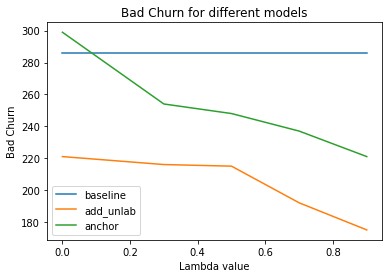

In [ ]:
import matplotlib.pyplot as plt

hyperparams = [0.0, 0.3, 0.5, 0.7, 0.9]

# plot accuracies for each model
for model in ['baseline', 'add_unlab', 'anchor']:
    model_accuracies = []
    for hyperparam in hyperparams:
        model_accuracies.append(metrics_dict_multiple[hyperparam]['bchurns_val'][model])
    plt.plot(hyperparams, model_accuracies, label=model)

plt.title('Bad Churn for different models')
plt.xlabel('Lambda value')
plt.ylabel('Bad Churn')
plt.legend()
plt.show()


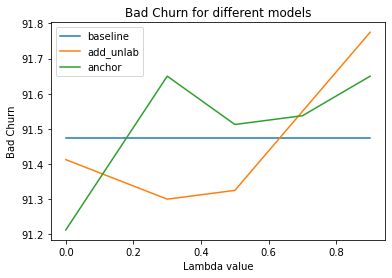

In [ ]:
hyperparams = [0.0, 0.3, 0.5, 0.7, 0.9]

# plot accuracies for each model
for model in ['baseline', 'add_unlab', 'anchor']:
    model_accuracies = []
    for hyperparam in hyperparams:
        model_accuracies.append(metrics_dict_multiple[hyperparam]['accuracies_val'][model])
    plt.plot(hyperparams, model_accuracies, label=model)

plt.title('Bad Churn for different models')
plt.xlabel('Lambda value')
plt.ylabel('Bad Churn')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
# create the pandas dataframe
df = pd.DataFrame.from_dict({(i,j): metrics_dict_multiple[i][j] 
                             for i in metrics_dict_multiple.keys() 
                             for j in metrics_dict_multiple[i].keys()},
                            orient='index')

# save the dataframe as a CSV file
df.to_csv('result_46.csv')